# Proyecto 1 - Visión por Computadora
## Ejercicio 1
## Integrantes:

- Javier Alvarado - 21188
- Mario Guerra - 21008
- Emilio Solano - 21212

### Binarización con Otsu

In [37]:
# Importar módulos y librerías para la binarización y métricas

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [38]:
# Método para cargar imágenes
def load_images(image_path):
    images = []
    filenames = []
    
    # Utilizar las imágenes .pgm y no las groundtruth
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.pgm') and not f.endswith('_gt.pgm') and f.split('.')[0].isdigit() and 1 <= int(f.split('.')[0]) <= 20], key=lambda x: int(x.split('.')[0]))
    
    for img_file in image_files:
        img = cv2.imread(os.path.join(image_path, img_file), cv2.IMREAD_GRAYSCALE)
        images.append(img)
        filenames.append(img_file)
    
    return images, filenames

In [39]:
def otsu_binarization(image):
    # Aplicar método de binarización de Otsu con OpenCV
    _, binary_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_img

In [40]:
def evaluate_metrics(original, binary):
    orig_flat = (original.flatten() > 127).astype(int)  # Convertimos a binario
    bin_flat = binary.flatten() // 255  # Convertimos la imagen binarizada a binario

    # Calcular métricas comparando con la imagen binarizada y la original
    accuracy = accuracy_score(orig_flat, bin_flat)
    precision = precision_score(orig_flat, bin_flat, zero_division=1)
    recall = recall_score(orig_flat, bin_flat, zero_division=1)
    f1 = f1_score(orig_flat, bin_flat, zero_division=1)
    
    tn, fp, fn, tp = confusion_matrix(orig_flat, bin_flat).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return accuracy, precision, recall, specificity, f1

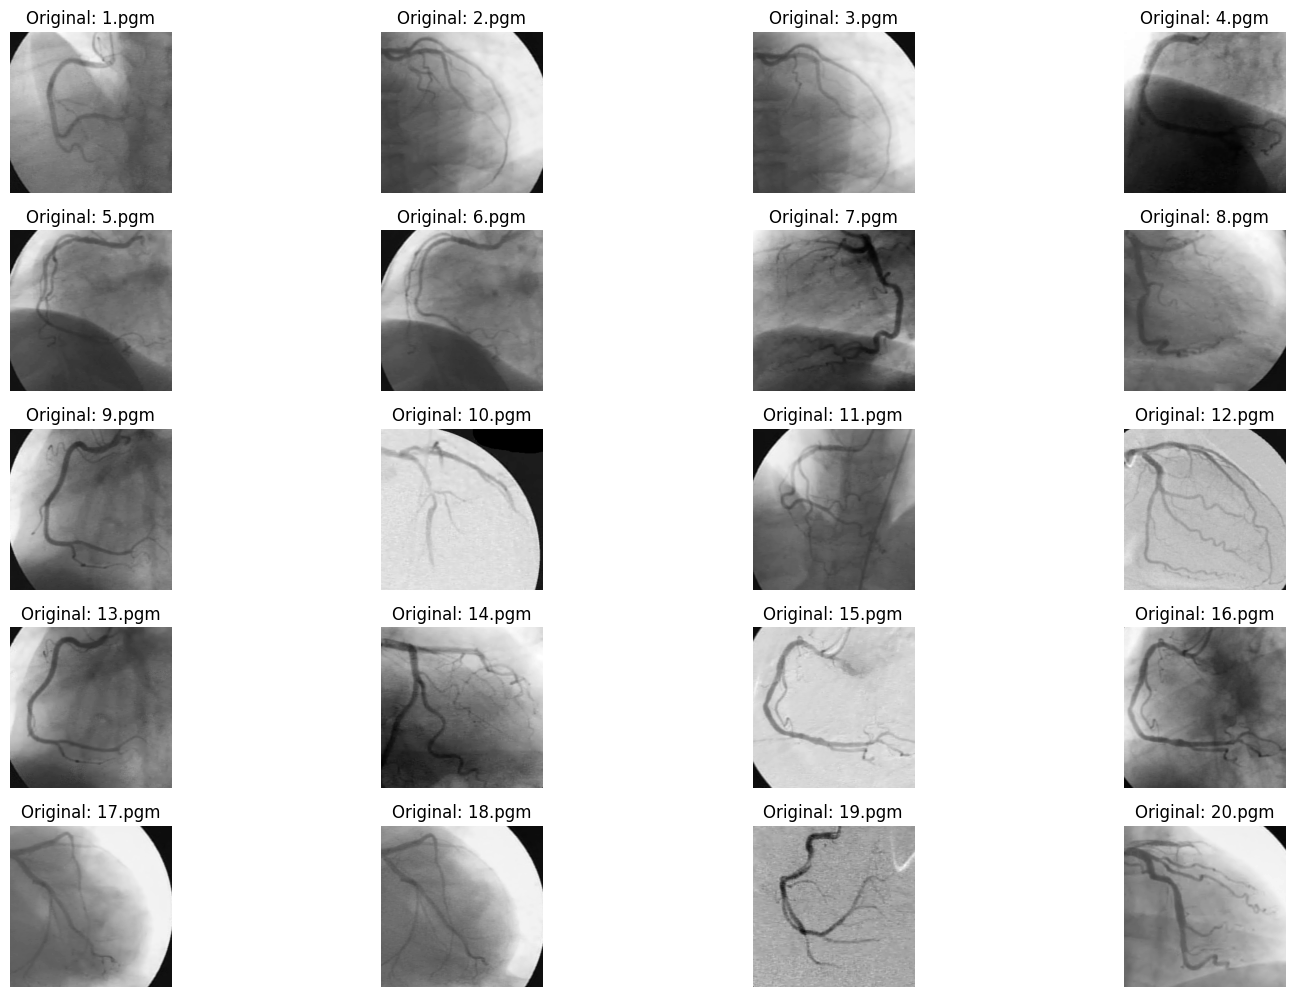

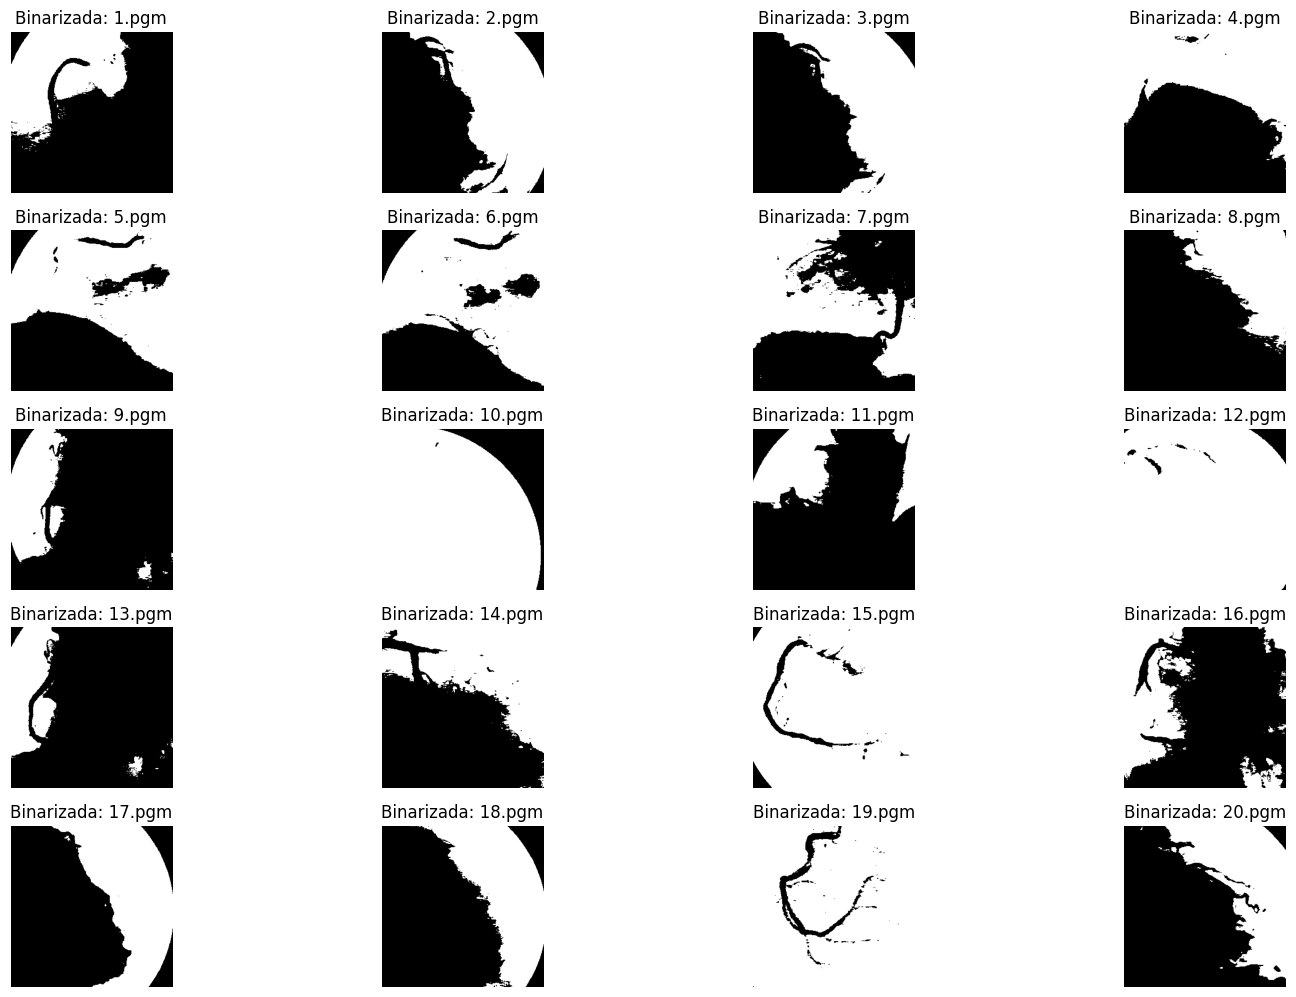

,Accuracy,Precision,Recall,Specificity,F1 Score
0,0.948222,0.832416,1.000000,0.930295,0.908545
1,0.913522,1.000000,0.844926,1.000000,0.915946
2,0.911122,1.000000,0.837965,1.000000,0.911840
3,0.987633,1.000000,0.972372,1.000000,0.985992
4,0.578089,0.251695,1.000000,0.508313,0.402166
5,0.544089,0.262121,1.000000,0.455982,0.415365
6,0.641200,0.220903,1.000000,0.600564,0.361869
7,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.914622,1.000000,0.701151,1.000000,0.824326
9,0.343056,0.225403,1.000000,0.187788,0.367884


In [44]:
image_path = 'data/database'  # Ruta donde están las imágenes .pgm

# Cargar imágenes y aplicar binarización de Otsu
images, filenames = load_images(image_path)
otsu_results = [otsu_binarization(img) for img in images]

# Mostrar imágenes originales y binarizadas.
plt.figure(figsize=(15, 20))
for i, (orig_img, fname) in enumerate(zip(images, filenames)):
    plt.subplot(10, 4, i + 1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Original: {fname}")
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 20))
for i, (bin_img, fname) in enumerate(zip(otsu_results, filenames)):
    plt.subplot(10, 4, i + 1)
    plt.imshow(bin_img, cmap='gray')
    plt.title(f"Binarizada: {fname}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Evaluar métricas en las 20 imágenes
evaluation_results = [evaluate_metrics(img, bin_img) for img, bin_img in zip(images, otsu_results)]

# Crear DataFrame con métricas
columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
df_results = pd.DataFrame(evaluation_results, columns=columns)

df_results.mean()  # Promedio de métricas para el método de Otsu

# Mostrar resultados
df_results